### Hands-on Challenge 

We are going to continue with our code from last week, except there will be a few changes:

-   We are exchanging the output vector of a layer with an input vector instead. This will make the code a little cleaner
-   Layers will now be subclasses of the *layer* super class
-   The name will now be changed to *FFNN* for *FeedForward Neural Network*, since we are expanding on what our network can do.

This way our FFNN package will be like a "mini pytorch", and our training code will be similar to how pytorch is used. Here is the complete code for our neural network class:

In [17]:
import numpy as np

class FFNN: #Previous MLP class
    def __init__(self):
        self.net = []
        self.output = None
        
        self.net.append(linearlayer(10,20))
        self.net.append(linearlayer(20,4))
        
        
    def forward(self, x):
        for layer in self.net:
            x = layer.forward(x)
        self.output = x
        return x

    def backward(self, error):
        #New
        for layer in reversed(self.net):
            error = layer.backward(error)

    def zero_grad(self):
        for layer in self.net:
            layer.zero_grad()

That is all there is to our network model. Nice and simple. All the rest of the work is done by the layers. We create an instance of a *FFNN* as before by appending layers to *self.net* and calling 
`model = FFNN()`

Here is the *layer* superclassThat is all there is to our network model. Nice and simple. All the rest of the work is done by the layers. We create an instance of a *FFNN* as before by appending layers to *self.net* and calling 
`model = FFNN()`

Here is the *layer* superclass

In [18]:
class layer:
    def __init__(self, node_dim):
        """
        This init should be called via super() with the number
        of nodes as an argument.
        """
        self.input = np.zeros(node_dim)
        self.input_grad = np.zeros(node_dim)
        self.params = False #New
        self.skip = False #New (for DropOut)

    def forward(self, x):
        self.input = x
        return x

    def backward(self):
        pass

    def parameters(self):
        pass

    def zero_grad(self):
        self.input_grad.fill(0.)

For any layer you are responsible for:

1.  initializing any additional parameters in `__init__()`. If you do, set the `self.params` flag to `True`.
2.  implementing the `forward` method.
3.  implementing the `backward` and, if applicable, `parameters` methods.

**Step #3** can be ignored for this week, it will be needed next week when we will implement gradient descent. 

This is what your layers should look like:

In [21]:
#This is a linear layer, on this notebook we won't use this class.
class linearlayer(layer): #previous linearlayer
    def __init__(self, in_dim, node_dim,bias=True): #args added
        super(linearlayer , self).__init__(node_dim)
        self.out = np.zeros(node_dim)
        self.weights = np.random.rand(node_dim, in_dim)
        self.params = True
        if bias:
            self.bias = np.zeros(in_dim)
        # if there are parameters, instantiate here and set 

    def forward(self, x):
        self.input = x
        self.out = np.dot(self.weights, x)
        if self.bias.any():
            self.out += self.bias
            
        return self.out

In [22]:
#Let's see if it works
model = FFNN()

x = np.random.random(10)

print(x)
print(model.forward(x))

[0.72491332 0.49421045 0.08515473 0.75585636 0.74595363 0.81577675
 0.70260292 0.74717362 0.00153236 0.33686705]
[31.82933322 30.33818012 33.37478287 22.6811728 ]


### Challenge for the Week 

Implement a 2D convolution layer. There is more than one way to calculate convolutions, but we are only asking for the most straight-forward way involving nested `for` loops. 
(Aside: Computing convolutions this way is slow, and that is not how it is implemented by current frameworks. However creating a fast implementation is beyond the scope of this workshop.) 

Here is a code snippet to get you started

In [44]:
class conv2d(layer):
    def __init__(self, in_c, out_c, kernel_size, params, stride=1, padding=0, bias=True):
        """
        A convolution layer kernel is made of weights to train.
        ----------------------------------------------------------------------
        Parameters:
        in_c: Input channel. If there is an rgb image this would be 3.
        out_c: Output channel. The desired channels in the output of the conv layer. Ideally one kernel per channel.
        kernel_size: symmetrically kernel size i.e. 3x3.
        stride: the kernel moves in increment of n strides.
        padding: number of padding creating around the image.
        params: (input_height, input_width)
        """
        super(conv2d, self).__init__(out_c)
        
        self.params = True
        self.bias = bias
        self.in_c = in_c
        self.out_c = out_c
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize trainable parameters
        self.w = np.random.randn(out_c, in_c, kernel_size, kernel_size) # random kernels (aka weights) tensor.
        
        if bias:
            self.b = np.zeros(out_c, 1, 1) # bias tensor 

    def forward(self, x):
        
        #save the input for backpopagation later
        self.input = x
        
        # pad the input with 0's on x and y axes.
        x = np.pad(x, [(0,0), (self.padding, self.padding),
                       (self.padding, self.padding)], 'constant')
        
        # calculate traversal using size of: x, kernel, stride, padding (see function below)
        iY = self.calc_traversal(x[0]) # traverse 2D input vertically
        iX = self.calc_traversal(x[0,0]) #traverse input horizontally
        
        # instantiate the output tensor
        result = np.zeros(( self.out_c, len(iY), len(iX)))
        
        # perform the convolution
        for idy in iY:
            
            for idx in iX:
                # compute dot product(s)
                result[:, idy, idx] = np.multiply(x[:,
                                                   idy:idy + self.kernel_size,
                                                   idx:idx + self.kernel_size],
                                                 self.w).sum(axis=(1,2,3))
        #add biases and return result
        
        return self.b + result
    
    def calc_traversal(self,x):
        # calculate traversal using values of: x.size, kernel.size, stride, padding
        idX = np.arange(
                    int(
                        (len(x) + 2 * self.padding - self.kernel_size) / self.stride 
                       ) + 1
                        )
        # change indices based on stride
        idX = idX * self.stride
        
        return idX

### Test the convolution layer

Let us take the Scharr and Sobel filters we created and use them as kernels (weights) in out convolution layer. Uncomment the filter that you want to use.

In [50]:
class conv2d(layer):
    def __init__(self, in_c, out_c, kernel_size, stride=1, padding=0, bias=False, method = 'sobel'):
        super(conv2d, self).__init__(out_c)
        self.params = True
        self.bias = bias
        self.in_c = in_c
        self.out_c = out_c
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # self.w = np.random.randn(out_c, in_c, kernel_size, kernel_size)
        self.b = np.zeros((out_c, 1, 1))

        # 1) Sobel Filter
        self.w = np.array(
            [
                [
                    [[-1, 0,  +1], [-2, 0, +2], [-1, 0,  +1]],
                    [[-1, 0,  +1], [-2, 0, +2], [-1, 0,  +1]],
                    [[-1, 0,  +1], [-2, 0, +2], [-1, 0,  +1]]
                ]
            ])

        # 2) Scharr Filter
        # self.w = np.array([
        #     [
        #         [[-3-3j, 0-10j,  +3 - 3j], [-10+0j, 0 + 0j, +10 + 0j], [-3+3j, 0+10j,  +3 + 3j]],
        #         [[-3-3j, 0-10j,  +3 - 3j], [-10+0j, 0 + 0j, +10 + 0j], [-3+3j, 0+10j,  +3 + 3j]],
        #         [[-3-3j, 0-10j,  +3 - 3j], [-10+0j, 0 + 0j, +10 + 0j], [-3+3j, 0+10j,  +3 + 3j]]
        #     ]
        # ])
        
        # 3) Regular random weigths
        # self.w = np.random.randn(out_c, in_c, kernel_size, kernel_size)
        
        
    def forward(self, x):
        self.input = x 

        x = np.pad(x, [(0, 0), (self.padding, self.padding),
                       (self.padding, self.padding)], 'constant')

        iY = self.calc_traversal(x[0])
        iX = self.calc_traversal(x[0, 0])

        result = np.zeros((self.out_c, len(iY), len(iX)))

        for idy in iY:
            for idx in iX:
                result[:, idy, idx] = np.multiply(x[:,
                                                    idy:idy + self.kernel_size,
                                                    idx:idx + self.kernel_size],
                                                  self.w).sum(axis=(1, 2, 3))
        return self.b + result

    def calc_traversal(self, x):
        idX = np.arange(
            int((len(x) + 2 * self.padding - self.kernel_size) / self.stride) + 1)
        idX = idX * self.stride
        return idX

Now go back to our eye image and try our handmade convolution layer on it.
First we need to reshape our image to conform to our shape standard: (channels, Y, X)

In [51]:
import matplotlib.pyplot as plt

img = plt.imread('veins.png') 

# get rid of the alpha channel
img = img[:, :, :3]

# permute the axes
img = np.transpose(img, (2, 0, 1))

Create a convolution layer and pass through the image. For a single channel output (1, Y, X), matplotlib doesn't understand, so we squeeze the array and remove it.

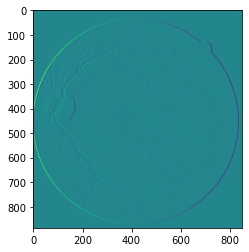

In [52]:
#Here we are returning a 1D image
conv_layer = conv2d(in_c=3, out_c =1, kernel_size=3)
filtered_img = conv_layer.forward(img)

# remove front single dimension axis
plt.imshow(filtered_img.squeeze())

How about returning a colour image? We don't need to 'squeeze', but we do need to permute the axis back to original form.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


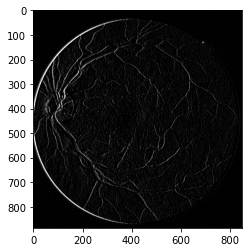

In [53]:
#We can also return a colour image
conv_layer = conv2d(3, 3, 3)
filtered_img = conv_layer.forward(img)

# permute axis to conform to pyplot standard
filtered_img = np.transpose(filtered_img, (1, 2, 0))

plt.imshow(filtered_img)

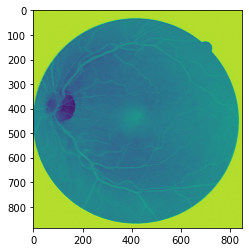

In [54]:
#Using regular random weights
# Regular random weights
conv_layers = conv2d(in_c = 3, out_c= 1, kernel_size=3)
conv_layers.w = np.random.randn(1, 1, 3, 3) #Quick way to change the layer weights.

filtered_img = conv_layers.forward(img)
plt.imshow(filtered_img.squeeze())

#### Convenience code cells

Use it to replace the kernel with the ones saw in previous notebook.

In [ ]:
# Sobel Filter
conv_layer.w = np.array(
    [
        [
            [[-1, 0,  +1], [-2, 0, +2], [-1, 0,  +1]],
            [[-1, 0,  +1], [-2, 0, +2], [-1, 0,  +1]],
            [[-1, 0,  +1], [-2, 0, +2], [-1, 0,  +1]]
        ]
    ])

In [ ]:
# Scharr Filter
conv_layer.w = np.array([
    [
        [[-3-3j, 0-10j,  +3 - 3j], [-10+0j, 0 + 0j, +10 + 0j], [-3+3j, 0+10j,  +3 + 3j]],
        [[-3-3j, 0-10j,  +3 - 3j], [-10+0j, 0 + 0j, +10 + 0j], [-3+3j, 0+10j,  +3 + 3j]],
        [[-3-3j, 0-10j,  +3 - 3j], [-10+0j, 0 + 0j, +10 + 0j], [-3+3j, 0+10j,  +3 + 3j]]
    ]
])